In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from project import clean_data, get_scores_ridge, get_data

In [2]:
np.random.seed(14)

In [3]:
data = pd.read_csv('train.csv', index_col=0)

In [4]:
data = data.drop([89,524,636,706,1299])

In [5]:
data = clean_data(data)

In [6]:
target = data.SalePrice

In [7]:
data = data.drop('SalePrice', axis=1)

In [8]:
columns = data.columns

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = .3)

In [10]:
y_train_binned = [0 if price <= 120000 else 1 if price <= 200000 else 2 for price in y_train]
y_test_binned  = [0 if price <= 120000 else 1 if price <= 200000 else 2 for price in y_test]

In [11]:
X_train_num = pd.get_dummies(X_train, drop_first=True)
X_test_num  = pd.get_dummies(X_test, drop_first=True)

# Models

#### Since we do not have enough data to split also for validation set we will use k-fold for validation

# Classification

In [12]:
def get_validation_scores_clf(clf, X):
    
    scores = cross_validate(clf, X, y_train_binned, cv=10, n_jobs=1, return_train_score=True,
                            scoring=['f1_macro', 'recall_macro', 'precision_macro', 'accuracy'])
    
    for score in ['train_f1_macro', 'train_recall_macro', 'train_precision_macro', 'train_accuracy',
                  'test_f1_macro', 'test_recall_macro', 'test_precision_macro', 'test_accuracy']:
        print(score, scores[score].mean())
        
    return scores

In [13]:
def get_test_score_clf(clf, columns=columns):
    clf.fit(X_train_num.loc[:,columns], y_train_binned)
    y_pred = clf.predict(X_test_num.loc[:,columns])
    
    f1 = f1_score(y_test_binned, y_pred, average='macro')
    accuracy = accuracy_score(y_test_binned, y_pred)
    recall = recall_score(y_test_binned, y_pred, average='macro')
    precision = precision_score(y_test_binned, y_pred, average='macro')
    
    print('f1_score (macro)', f1)
    print('accuracy_score', accuracy)
    print('recall_score (macro)', recall)
    print('precision_score (macro)', precision)
    
    return {'f1':f1, 'accuracy':accuracy, 'recall':recall, 'precision':precision}

### Dummy Classifier

In [14]:
clf_dummy = DummyClassifier('most_frequent')

In [15]:
val_scores_clf_dummy = get_validation_scores_clf(clf_dummy, X_train_num)

train_f1_macro 0.2275475220267404
train_recall_macro 0.33333333333333337
train_precision_macro 0.1727302974989094
train_accuracy 0.5181908924967281
test_f1_macro 0.2275496270802373
test_recall_macro 0.33333333333333337
test_precision_macro 0.17273389714756743
test_accuracy 0.5182016914427022


/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
test_scores_clf_dummy = get_test_score_clf(clf_dummy)

f1_score (macro) 0.23184079601990049
accuracy_score 0.5331807780320366
recall_score (macro) 0.3333333333333333
precision_score (macro) 0.17772692601067885


/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


### Random Forest Classifier

In [17]:
best_params_rfc={'max_depth': 20,
                 'min_samples_leaf': 3,
                 'min_samples_split': 8,
                 'n_estimators': 100}

In [18]:
rfc_features = ['BsmtFinSF1',
 'GarageArea',
 'GrLivArea',
 'LotArea',
 'MiscVal',
 'OverallQual',
 'TotalBsmtSF']

In [19]:
clf_rf = RandomForestClassifier(**best_params_rfc)

In [20]:
val_scores_clf_rf = get_validation_scores_clf(clf_rf, X_train_num.loc[:,rfc_features])

train_f1_macro 0.9362245609295536
train_recall_macro 0.9232344328264668
train_precision_macro 0.9522937528358334
train_accuracy 0.9424256713219938
test_f1_macro 0.8097853991726909
test_recall_macro 0.7903445662551277
test_precision_macro 0.8433565655151808
test_accuracy 0.8280306774252525


In [21]:
test_scores_clf_rf = get_test_score_clf(clf_rf, rfc_features)

f1_score (macro) 0.8110689920948051
accuracy_score 0.8283752860411899
recall_score (macro) 0.8053906541157235
precision_score (macro) 0.8214717224918137


### SVC Classifier

In [22]:
best_params_svc = {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}

In [23]:
svc_features = ['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'ExterQual',
 'GarageArea',
 'GarageFinish',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'MiscVal',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt']

In [24]:
clf_svc = Pipeline([('scaler', StandardScaler()), ('classifier', SVC(**best_params_svc))])

In [25]:
val_scores_clf_svc = get_validation_scores_clf(clf_svc, X_train_num.loc[:, svc_features])

train_f1_macro 0.8341622749061172
train_recall_macro 0.8100834099270703
train_precision_macro 0.8738345240133493
train_accuracy 0.8529465011867259
test_f1_macro 0.817839868932561
test_recall_macro 0.7956379833400368
test_precision_macro 0.8618894432429327
test_accuracy 0.8408254519341141


In [26]:
test_scores_clf_svc = get_test_score_clf(clf_svc, svc_features)

f1_score (macro) 0.8252475673813829
accuracy_score 0.8489702517162472
recall_score (macro) 0.8069318714610308
precision_score (macro) 0.8567973540572374


In [50]:
print([val_scores_clf_dummy['test_f1_macro'].std(),
              val_scores_clf_rf['test_f1_macro'].std(),
              val_scores_clf_svc['test_f1_macro'].std()])

0.0006733632111376462 0.04285034378236204 0.051259169328772315


In [51]:
print([val_scores_clf_dummy['test_accuracy'].std(),
              val_scores_clf_rf['test_accuracy'].std(),
              val_scores_clf_svc['test_accuracy'].std()])

[0.0023250079343804337, 0.038329483446028524, 0.03565814067546885]


In [55]:
print([val_scores_clf_dummy['test_recall_macro'].std(),
              val_scores_clf_rf['test_recall_macro'].std(),
              val_scores_clf_svc['test_recall_macro'].std()])

[5.551115123125783e-17, 0.04469248484639341, 0.05576784743462415]


In [56]:
print([val_scores_clf_dummy['test_precision_macro'].std(),
              val_scores_clf_rf['test_precision_macro'].std(),
              val_scores_clf_svc['test_precision_macro'].std()])

[0.0007750026447934849, 0.046503431828439266, 0.03785522743464524]


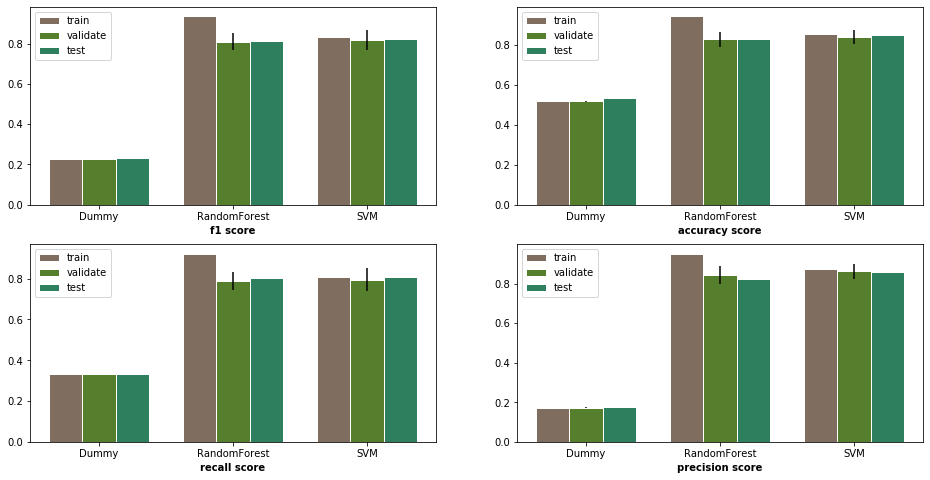

In [54]:
plt.figure(figsize=(16,8))
barWidth = 0.25

#f1
plt.subplot(2,2,1)
val_error = [val_scores_clf_dummy['test_f1_macro'].std(),
              val_scores_clf_rf['test_f1_macro'].std(),
              val_scores_clf_svc['test_f1_macro'].std()]

# set height of bar
train = [val_scores_clf_dummy['train_f1_macro'].mean(),
         val_scores_clf_rf['train_f1_macro'].mean(),
         val_scores_clf_svc['train_f1_macro'].mean()]
validation = [val_scores_clf_dummy['test_f1_macro'].mean(),
              val_scores_clf_rf['test_f1_macro'].mean(),
              val_scores_clf_svc['test_f1_macro'].mean()]
test = [test_scores_clf_dummy['f1'], test_scores_clf_rf['f1'], test_scores_clf_svc['f1']]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error)
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.xlabel('f1 score', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train))], ['Dummy', 'RandomForest', 'SVM'])
plt.legend()

#accuracy
plt.subplot(2,2,2)
val_error = [val_scores_clf_dummy['test_accuracy'].std(),
              val_scores_clf_rf['test_accuracy'].std(),
              val_scores_clf_svc['test_accuracy'].std()]

# set height of bar
train = [val_scores_clf_dummy['train_accuracy'].mean(),
         val_scores_clf_rf['train_accuracy'].mean(),
         val_scores_clf_svc['train_accuracy'].mean()]
validation = [val_scores_clf_dummy['test_accuracy'].mean(),
              val_scores_clf_rf['test_accuracy'].mean(),
              val_scores_clf_svc['test_accuracy'].mean()]
test = [test_scores_clf_dummy['accuracy'], test_scores_clf_rf['accuracy'], test_scores_clf_svc['accuracy']]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error)
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.xlabel('accuracy score', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train))], ['Dummy', 'RandomForest', 'SVM'])
plt.legend()

#recall
plt.subplot(2,2,3)
val_error = [val_scores_clf_dummy['test_recall_macro'].std(),
              val_scores_clf_rf['test_recall_macro'].std(),
              val_scores_clf_svc['test_recall_macro'].std()]

# set height of bar
train = [val_scores_clf_dummy['train_recall_macro'].mean(),
         val_scores_clf_rf['train_recall_macro'].mean(),
         val_scores_clf_svc['train_recall_macro'].mean()]
validation = [val_scores_clf_dummy['test_recall_macro'].mean(),
              val_scores_clf_rf['test_recall_macro'].mean(),
              val_scores_clf_svc['test_recall_macro'].mean()]
test = [test_scores_clf_dummy['recall'], test_scores_clf_rf['recall'], test_scores_clf_svc['recall']]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error)
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.xlabel('recall score', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train))], ['Dummy', 'RandomForest', 'SVM'])
plt.legend()

#precision
plt.subplot(2,2,4)
val_error = [val_scores_clf_dummy['test_precision_macro'].std(),
              val_scores_clf_rf['test_precision_macro'].std(),
              val_scores_clf_svc['test_precision_macro'].std()]

# set height of bar
train = [val_scores_clf_dummy['train_precision_macro'].mean(),
         val_scores_clf_rf['train_precision_macro'].mean(),
         val_scores_clf_svc['train_precision_macro'].mean()]
validation = [val_scores_clf_dummy['test_precision_macro'].mean(),
              val_scores_clf_rf['test_precision_macro'].mean(),
              val_scores_clf_svc['test_precision_macro'].mean()]
test = [test_scores_clf_dummy['precision'], test_scores_clf_rf['precision'], test_scores_clf_svc['precision']]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train');
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error);
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test');
 
# Add xticks on the middle of the group bars
plt.xlabel('precision score', fontweight='bold');
plt.xticks([r + barWidth for r in range(len(train))], ['Dummy', 'RandomForest', 'SVM']);
plt.legend();



# Regression

In [28]:
y_train_log = np.log(y_train)

In [29]:
y_test_log = np.log(y_test)

In [30]:
def get_validation_scores_reg(reg, X):
    
    scores = cross_validate(reg, X, y_train_log, cv=10, n_jobs=1, return_train_score=True)
    
    for score in ['train_score', 'test_score']:
        print(score, scores[score].mean())
        
    return scores

In [31]:
def get_test_score_reg(reg, columns=columns):
    reg.fit(X_train_num.loc[:,columns], y_train_log)
    score = reg.score(X_test_num.loc[:,columns], y_test_log)
    
    print(score)
    return score

### Linear Regression

#### Ridge Regularization

In [32]:
lr_features = ['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'EnclosedPorch',
 'ExterQual',
 'Fireplaces',
 'GarageArea',
 'GarageFinish',
 'GarageType_Detchd',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'ScreenPorch',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

In [33]:
reg_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=.05))])

In [34]:
val_scores_reg_ridge = get_validation_scores_reg(reg_ridge, X_train_num.loc[:,lr_features])

train_score 0.9074269743267204
test_score 0.8992762271487311


In [35]:
test_score_reg_ridge = get_test_score_reg(reg_ridge, lr_features)

0.892623556439032


#### Lasso Regularization

In [36]:
reg_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])

In [37]:
val_scores_reg_lasso = get_validation_scores_reg(reg_lasso, X_train_num.loc[:,lr_features])

train_score 0.9073082736423019
test_score 0.8993150446798763


In [38]:
test_score_reg_lasso = get_test_score_reg(reg_lasso, lr_features)

0.8938701438797594


### Random Forest Regression

In [39]:
best_params_rf = {'max_depth': 30,
                  'min_samples_leaf': 1,
                  'min_samples_split': 2,
                  'n_estimators': 300}

In [40]:
rf_features = ['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'ExterQual',
 'GarageArea',
 'GarageFinish',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'MiscVal',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt']

In [41]:
reg_rf = RandomForestRegressor(**best_params_rf)

In [42]:
val_scores_reg_rf = get_validation_scores_reg(reg_rf, X_train_num.loc[:, rf_features])

train_score 0.982299857026382
test_score 0.8653374918145496


In [43]:
test_score_reg_rf = get_test_score_reg(reg_rf, rf_features)

0.8653296343750956


### SVM Regression

In [44]:
best_params_svr = {'C': 0.1, 'kernel': 'linear'}

In [45]:
svr_features = ['1stFlrSF',
 '2ndFlrSF',
 'BsmtFinSF1',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'EnclosedPorch',
 'ExterQual',
 'Fireplaces',
 'GarageArea',
 'GarageFinish',
 'GarageType_Detchd',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'ScreenPorch',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd']

In [46]:
reg_svr = Pipeline([('scaler', StandardScaler()), ('estimator', SVR(**best_params_svr))])

In [47]:
val_scores_reg_svr = get_validation_scores_reg(reg_svr, X_train_num.loc[:, svr_features])

train_score 0.9057892422310181
test_score 0.8987882583891276


In [48]:
test_score_reg_svr = get_test_score_reg(reg_svr, svr_features)

0.8954935569599229


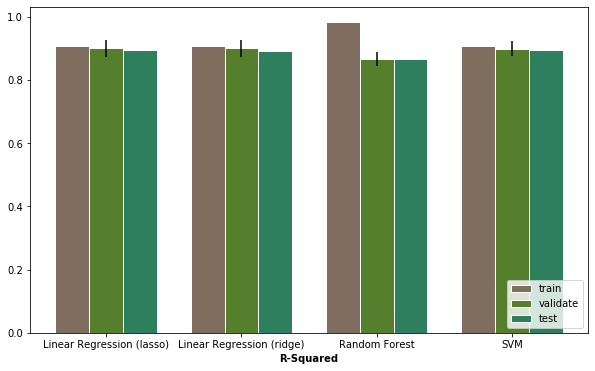

In [49]:
plt.figure(figsize=(10,6))
barWidth = 0.25
val_error = [val_scores_reg_lasso['test_score'].std(),
             val_scores_reg_ridge['test_score'].std(),
             val_scores_reg_rf['test_score'].std(),
             val_scores_reg_svr['test_score'].std()]

# set height of bar
train = [val_scores_reg_lasso['train_score'].mean(),
         val_scores_reg_ridge['train_score'].mean(),
         val_scores_reg_rf['train_score'].mean(),
         val_scores_reg_svr['train_score'].mean()]
validation = [val_scores_reg_lasso['test_score'].mean(),
              val_scores_reg_ridge['test_score'].mean(),
              val_scores_reg_rf['test_score'].mean(),
              val_scores_reg_svr['test_score'].mean()]
test = [test_score_reg_lasso, test_score_reg_ridge, test_score_reg_rf, test_score_reg_svr]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error)
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.xlabel('R-Squared', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train))], ['Linear Regression (lasso)',
                                                       'Linear Regression (ridge)', 
                                                       'Random Forest',
                                                       'SVM'])
plt.legend(loc=4)